In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL-H1


In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
#!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

2.10.0


In [2]:
import sys
sys.path.append('../../../Utils/')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [3]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [4]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]
print("Dataset Size" + str(dataset_size))

#SPLIT and NORMALIZE OUR DATASET
X_train,X_test,X_val,Y_train,Y_test,Y_val = dataset_helper.split_and_normalize(X,Y,split_test=0.1,split_val=0.1,normalization_mode = 1)

#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])
X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train,2000, disable_tqdm=True)


Dataset Size3542
Data Augmentation with data distribution
Data distribution = [0.229375 0.088875 0.095375 0.097375 0.089375 0.214375 0.086875 0.098375]
Class Size :  151, generating: 458
430 images generated
Class Size :  432, generating: 177
160 images generated
Class Size :  419, generating: 190
160 images generated
Class Size :  415, generating: 194
192 images generated
Class Size :  431, generating: 178
160 images generated
Class Size :  181, generating: 428
394 images generated
Class Size :  436, generating: 173
160 images generated
Class Size :  413, generating: 196
192 images generated


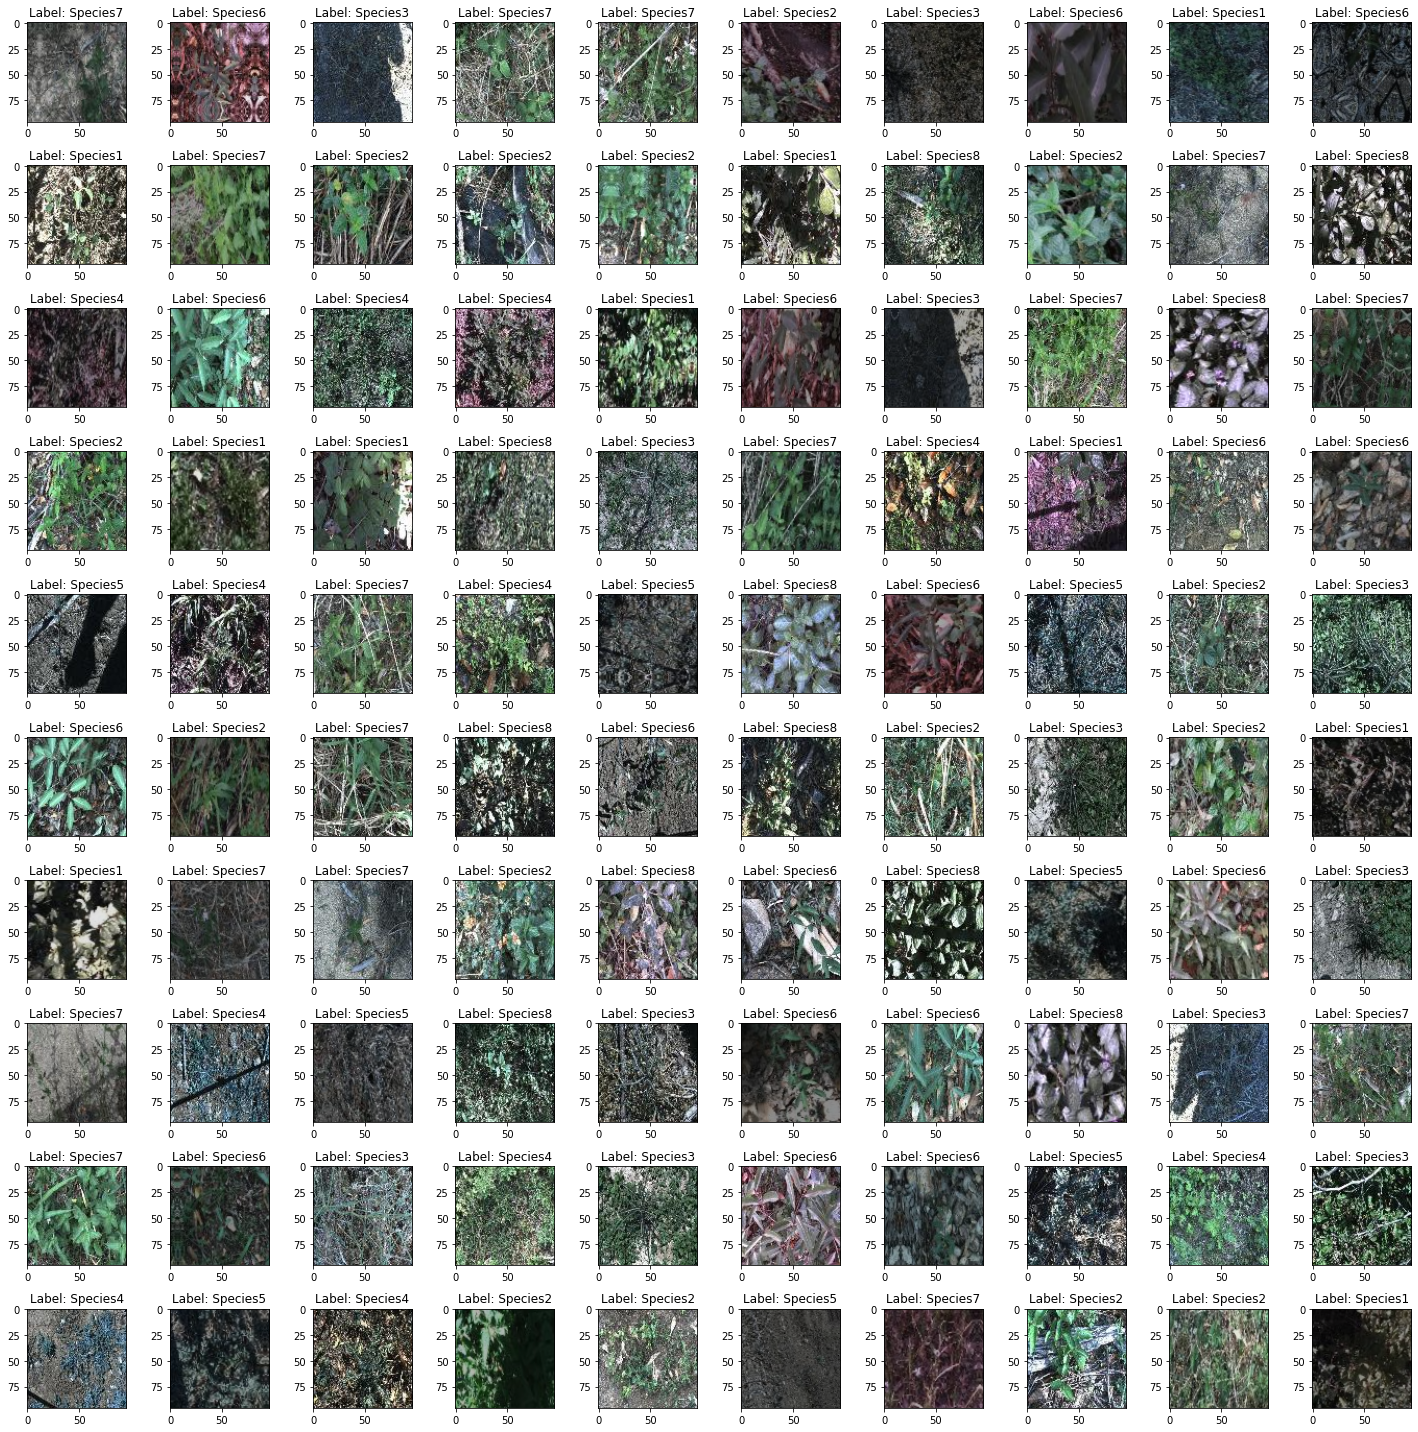

In [5]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns*rows +1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: '+ labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i=i-1
fig.tight_layout()
plt.show()

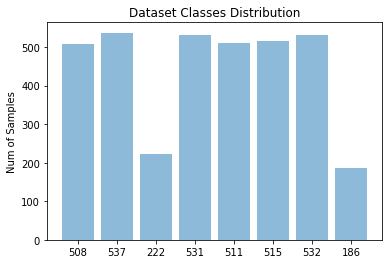

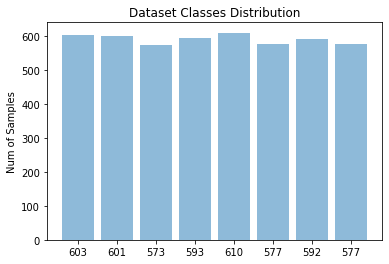

In [6]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

# Define the model Structure
Create a function that declare all the model components

In [14]:
def stackDenseLayer(layer_name,last_layer,size=256, activation='relu', drop_out = False,drop_rate=0.5):
    dense_layer = tfkl.Dense(
        units=size, 
        name=layer_name, 
        activation=activation,
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(last_layer)

    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)
    
    return dense_layer


In [44]:
def stackConvolutionLayer(layer_name,last_layer,kernel_size = (3,3), num_of_filter = 32,strides= (1,1),activation = 'relu',padding = 'same',pooling_size=(2,2),batch_normalization=False,num_of_stacked_conv=1):
    layer_activation = activation

    for i in range(0,num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)
        
        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv =tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides = strides,
            padding = padding,
            activation = layer_activation,
            name=curr_name,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv-1: #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv
    
        pool = tfkl.MaxPooling2D(pool_size = pooling_size)(last_layer)

    return pool

In [ ]:
def fineTuning(keras_model,input_shape,input_layer,num_of_unfreezed_layers = 0):
    base = keras_model(include_top=False,weights="imagenet",input_shape=input_shape)

    for i in range(0,num_of_unfreezed_layers):
            base.layers[i].layer.trainable=False
    
    base = base(input_layer, training=True)
    return base

In [47]:
#Create the Model
def build_model(input_shape):
    tf.random.set_seed(seed)

    inputs = keras.Input(shape=input_shape)

    #Load a pretrained Model (eg: VGG) [Model,input_shape,input_layer,num_of_unfreezed_layers]
    pretrained_model = fineTuning(tfk.applications.vgg19,input_shape,inputs,num_of_unfreezed_layers=8)
    pretrained_model = 

    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dense(1024, activation='relu')(x)
    drop = tfkl.Dropout(0.5, seed=seed)(x)
    output_layer = stackDenseLayer('Output',classifier,size=8)
    

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

# Training Phase
Compile the model, configure all necessary infomation for training like epoch,batches, callbacks...
Then start the training

### Compile the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 batch_normalization_14 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264 

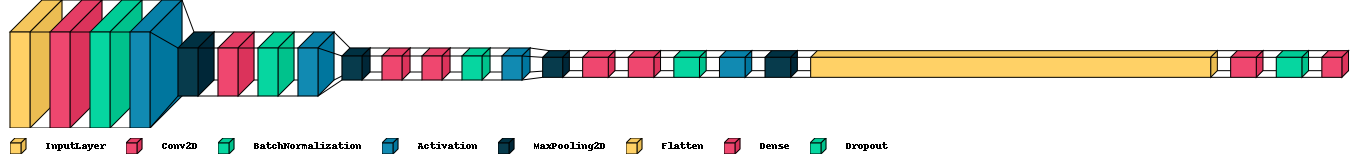

In [48]:
#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

### Train the model

In [20]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=25)

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200
70/70 [==============================] - 7s 74ms/step - loss: 2.0390 - accuracy: 0.2142 - val_loss: 2.2709 - val_accuracy: 0.1509
Epoch 2/200
70/70 [==============================] - 5s 70ms/step - loss: 1.9886 - accuracy: 0.2058 - val_loss: 2.1235 - val_accuracy: 0.3113
Epoch 3/200
70/70 [==============================] - 5s 69ms/step - loss: 1.8859 - accuracy: 0.2709 - val_loss: 1.8160 - val_accuracy: 0.2642
Epoch 4/200
70/70 [==============================] - 5s 70ms/step - loss: 1.7482 - accuracy: 0.3274 - val_loss: 1.6592 - val_accuracy: 0.3774
Epoch 5/200
70/70 [==============================] - 5s 71ms/step - loss: 1.6312 - accuracy: 0.3792 - val_loss: 2.2778 - val_accuracy: 0.2516
Epoch 6/200
70/70 [==============================] - 5s 71ms/step - loss: 1.5670 - accuracy: 0.4028 - val_loss: 1.4898 - val_accuracy: 0.4308
Epoch 7/200
 5/70 [=>............................] - ETA: 4s - loss: 1.5188 - accuracy: 0.4219

KeyboardInterrupt: ignored

In [10]:
#model_helper.save_model(model,"ExampleModel4")

model = model_helper.load_model("ExampleModel3")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       73856 

12/12 [==============================] - 0s 14ms/step
Accuracy: 0.5791
Precision: 0.5179
Recall: 0.5156
F1: 0.5122


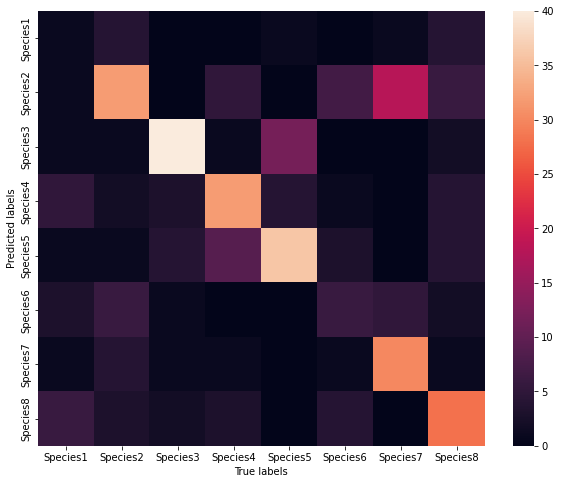

BABABA


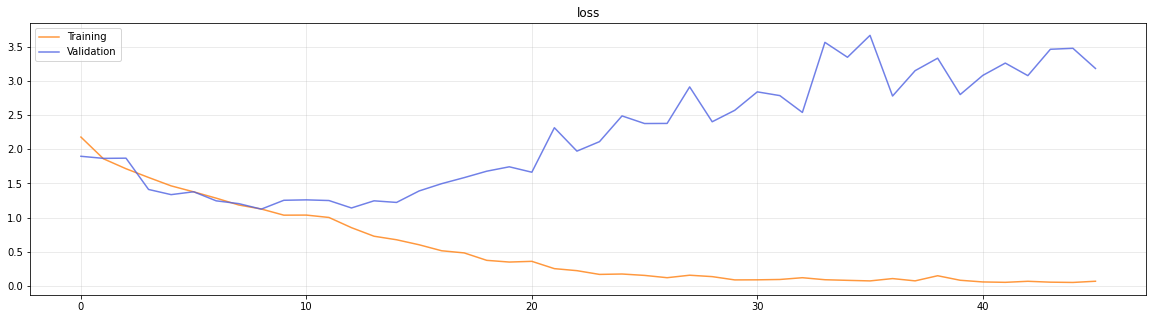

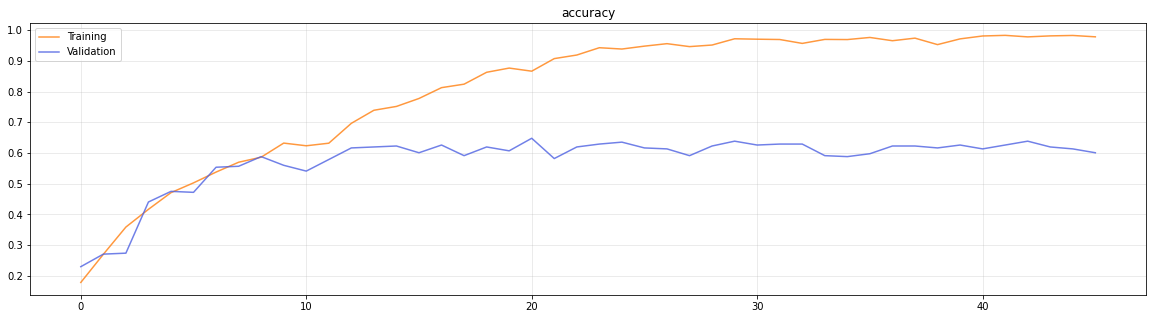

In [13]:
model_helper.show_confusion_matrix(X_test,Y_test)
model_helper.plot_phase_train_vs_validation(history)